# Potato Leaf Diseases Classification Model

Download dataset langsung dari Kaggle

In [ ]:
!kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld

Dataset URL: https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld
License(s): DbCL-1.0
 88% 33.0M/37.4M [00:00<00:00, 76.4MB/s]
100% 37.4M/37.4M [00:00<00:00, 86.1MB/s]


Import library yang dibutuhkan

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile

Karena format file yang didownload dari Kaggle berbentuk zip, maka kita harus mengekstrak file zip tersebut

In [ ]:
zip_path = '/content/potato-disease-leaf-datasetpld.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/potato leaves disease')

Memisahkan training, validation dan testing direktori lalu mengecek total foto tiap kelas dari seluruh direktori

## Image Preprocessing

In [ ]:
training_dir = '/content/potato leaves disease/PLD_3_Classes_256/Training'
val_dir = '/content/potato leaves disease/PLD_3_Classes_256/Validation'
test_dir = '/content/potato leaves disease/PLD_3_Classes_256/Testing'

for folder in os.listdir(training_dir):
    item_path = os.path.join(training_dir, folder)

    print(f'Total foto training {folder}: {len(os.listdir(item_path))}')

print('\n')

for folder in os.listdir(val_dir):
    item_path = os.path.join(val_dir, folder)

    print(f'Total foto validasi {folder}: {len(os.listdir(item_path))}')

print('\n')

for folder in os.listdir(test_dir):
    item_path = os.path.join(test_dir, folder)

    print(f'Total foto testing {folder}: {len(os.listdir(item_path))}')

Total foto training Late_Blight: 1132
Total foto training Early_Blight: 1303
Total foto training Healthy: 816


Total foto validasi Late_Blight: 151
Total foto validasi Early_Blight: 163
Total foto validasi Healthy: 102


Total foto testing Late_Blight: 141
Total foto testing Early_Blight: 162
Total foto testing Healthy: 102


Melihat sampel foto tiap kelas menggunakan matplotlib

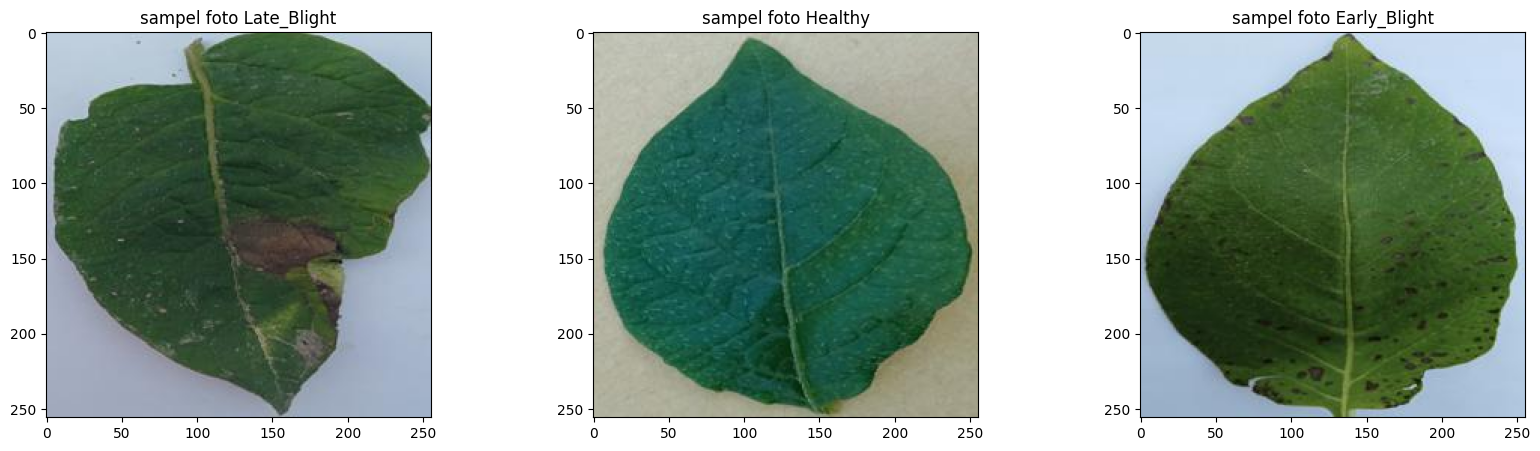

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(4 * 5, 5))
for i, folder in enumerate(os.listdir(training_dir)):
    item_path = os.path.join(training_dir, folder)
    sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')
    axs[i].imshow(sample_image)
    axs[i].set_title(f'sampel foto {folder}')
plt.show()

Melihat total pixel dari setiap foto

In [ ]:
for folder in os.listdir(training_dir):
    item_path = os.path.join(training_dir, folder)
    sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')
    sample_array = img_to_array(sample_image)
    print(f'Sampel foto {folder} memiliki pixel : {sample_array.shape}')

Sampel foto Late_Blight memiliki pixel : (256, 256, 3)
Sampel foto Healthy memiliki pixel : (256, 256, 3)
Sampel foto Early_Blight memiliki pixel : (256, 256, 3)


Menskalakan pixel foto agar berada diantara rentang 0 dan 1 menggunakan imagedatagenerator dan membuat label per kelas berdasarkan nama direktori menggunakan method dari imagedatagenerator yaitu flow_from_directory

In [ ]:
image_size = (224, 224)

def train_val_generators(train_dir, val_dir, test_dir):
  datagen = ImageDataGenerator(rescale=1.0/255.0)

  train_generator = datagen.flow_from_directory(directory=train_dir,
                                                batch_size=128,
                                                class_mode='categorical',
                                                target_size=image_size)

  val_generator = datagen.flow_from_directory(directory=val_dir,
                                              batch_size=32,
                                              class_mode='categorical',
                                              target_size=image_size)

  test_generator = datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False,
                                               target_size=image_size)

  return train_generator, val_generator, test_generator

train_generator, val_generator, test_generator = train_val_generators(training_dir, val_dir, test_dir)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


## Building and Training Model

Membuat model dengan menggunakan MobileNetV2 sebagai base model dan dilanjut dengan layer flatten untuk meratakan output dari base model.

In [ ]:
def create_model():
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_size + (3,))

  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu')(x)
  output = layers.Dense(3, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=output)

  model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.8),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

Melihat arsitektur model

In [ ]:
model = create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Memulai masa training dengan method .fit

In [ ]:
history = model.fit(train_generator,
          epochs = 15,
          verbose = 2,
          validation_data = val_generator)

Epoch 1/15
26/26 - 222s - loss: 7.3532 - accuracy: 0.6392 - val_loss: 0.2109 - val_accuracy: 0.9183 - 222s/epoch - 9s/step
Epoch 2/15
26/26 - 236s - loss: 0.2127 - accuracy: 0.9197 - val_loss: 0.3162 - val_accuracy: 0.8798 - 236s/epoch - 9s/step
Epoch 3/15
26/26 - 219s - loss: 0.1320 - accuracy: 0.9492 - val_loss: 0.1998 - val_accuracy: 0.9255 - 219s/epoch - 8s/step
Epoch 4/15
26/26 - 215s - loss: 0.0731 - accuracy: 0.9751 - val_loss: 0.1926 - val_accuracy: 0.9351 - 215s/epoch - 8s/step
Epoch 5/15
26/26 - 213s - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.1785 - val_accuracy: 0.9399 - 213s/epoch - 8s/step
Epoch 6/15
26/26 - 215s - loss: 0.0166 - accuracy: 0.9963 - val_loss: 0.1888 - val_accuracy: 0.9375 - 215s/epoch - 8s/step
Epoch 7/15
26/26 - 215s - loss: 0.0078 - accuracy: 0.9997 - val_loss: 0.2053 - val_accuracy: 0.9351 - 215s/epoch - 8s/step
Epoch 8/15
26/26 - 215s - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.1956 - val_accuracy: 0.9423 - 215s/epoch - 8s/step
Epoch 9/15
26/26

## Model Evaluation

Membuat fungsi untuk menampilkan plot akurasi dan loss untuk data training dan validasi semasa training

In [ ]:
def create_plot(history, string):
  plt.plot(history.history[string], 'r', label='Training '+string)
  plt.plot(history.history['val_'+string], 'b', label='Validation '+string)
  plt.title('Training and validation '+string)
  plt.legend()
  plt.show()
  print('')

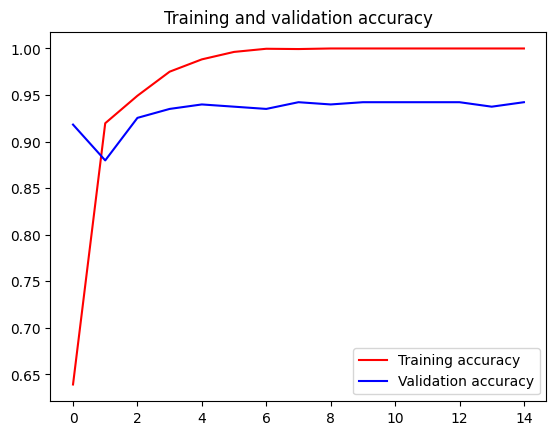

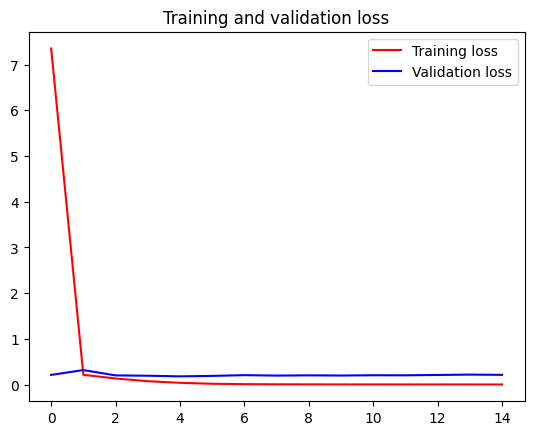

In [ ]:
create_plot(history, 'accuracy')
create_plot(history, 'loss')

Evaluasi model dengan data testing

In [ ]:
model.evaluate(test_generator)

13/13 [==============================] - 19s 1s/step - loss: 0.2637 - accuracy: 0.9457


[0.26371654868125916, 0.9456790089607239]

Mengambil Hasil prediksi tertinggi untuk bisa memplot confusion matrix dan matriks evaluasi lainnya

In [ ]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

13/13 [==============================] - 26s 2s/step


Membuat fungsi untuk menampilkan confusion matrix

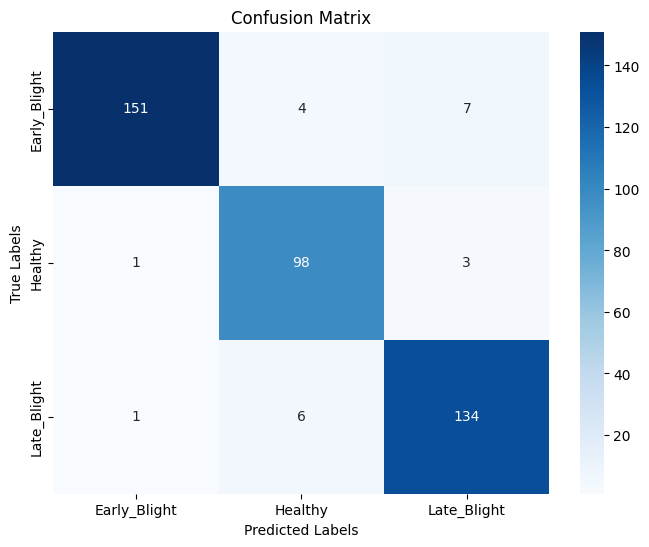

In [ ]:
def plot_confusion_matrix(test_generator, y_true, y_pred):
    class_names = list(test_generator.class_indices.keys())

    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_generator, y_true, y_pred)

Melihat matriks evaluasi precision, recall dan f1-score

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       162
           1       0.91      0.96      0.93       102
           2       0.93      0.95      0.94       141

    accuracy                           0.95       405
   macro avg       0.94      0.95      0.94       405
weighted avg       0.95      0.95      0.95       405



Save model

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Memanggil model yang telah disave

In [ ]:
'''
model = '/content/model.h5'

'''

Membuat fungsi untuk preprocess gambar yang akan diinput

In [ ]:
def open_image(img):
  image = load_img(img, target_size=image_size)
  img = img_to_array(image)
  img = np.expand_dims(img, axis=0)
  preprocess_img = preprocess_input(img)

  return preprocess_img, image

Membuat fungsi untuk memprediksi gambar yang diinput

In [ ]:
def predict_image(img):
  preprocess_img, image = open_image(img)
  predictions = model.predict(preprocess_img)
  predicted_class_idx = np.argmax(predictions)

  class_indices = train_generator.class_indices
  labels = list(class_indices.keys())
  predicted_class_label = labels[predicted_class_idx]

  plt.imshow(image)

  plt.axis('off')
  plt.title(f'Predicted Label: {predicted_class_label}')

  plt.show()

Prediksi gambar yang diinput

Saving EB lesions1_opt.jpeg to EB lesions1_opt.jpeg
1/1 [==============================] - 0s 83ms/step


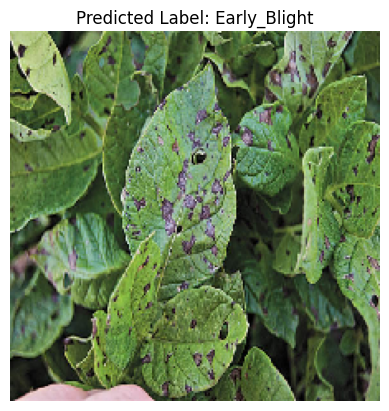

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  predict_image(fn)